In [1]:
import degirum as dg
import mytools
import numpy as np
import cv2
from custom_postprocessors.Yolov6FaceDetection import Yolov6FaceDetection

In [2]:
cloud_zoo_url='https://cs.degirum.com/degirum/openvino'
cloud_token = mytools.get_token() # get cloud API access token from env.ini file
zoo = dg.connect(dg.CLOUD,cloud_zoo_url,cloud_token)
model = zoo.load_model("yolo_v6n_face--512x512_float_openvino_cpu_1",cloud_token)
model.custom_postprocessor = Yolov6FaceDetection
model.image_backend = 'pil'

model.overlay_show_probabilities = False
model.overlay_show_labels = False
res = model("./images/ThreePersons.jpg")

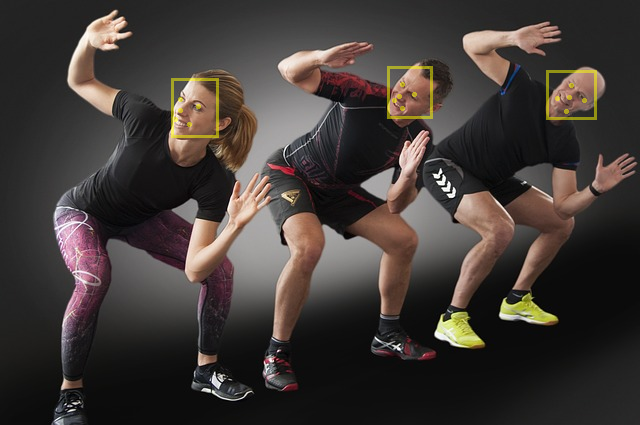

In [3]:
res.image_overlay